# Quick limits

**Goal:** I just wanted to start to pop out some limits for these different categories.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../PAG-opt/','../code/']
from analysis import getXhh
from utils import mcToYr, L
from postprocess import calc_bstrap

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
df = pd.DataFrame(0,[16,17,18,'all'],['base stat','base syst','deta stat','deta syst','deta corr'])

In [3]:
df

base stat  base syst  deta stat  deta syst  deta corr
16           0          0          0          0          0
17           0          0          0          0          0
18           0          0          0          0          0
all          0          0          0          0          0

In [4]:
os.chdir('../non-resonant-studies/')

for i, yr in zip(df.index,[16,17,18,'16-17-18']):
    
    for c,opTag,cat,l in zip(df.columns, 
                             ['stat-only','systs-HTcut-300.0','stat-only','systs-HTcut-300.0','systs-HTcut-300.0'],
                             ['']*2+['-dEta_hh-cat']*2+['-dEta_hh-cat-corr'],
                             ['baseline']*2+['3_bins']*3):
    

        limFile = f'../stats-results/dEta_cats/lim-{opTag}{cat}-{yr}-SM-HH-{l}.csv'
        dfi = pd.read_csv(limFile)
        
        df.loc[i,c] = dfi.loc[0,'Exp']
        

        # For the systs configs, - also get the pull, impact, and correlation plots
        if i=='all':
            ws_file = limFile.replace('lim','ws').replace('.csv','.json')
            print(ws_file)
            #if not os.path.exists(ws_file.replace('.json','_correlations.csv')):
            cmd = f'python run_pulls.py -i {ws_file} --pulls  --correlations'
            print(cmd)
#                 #os.system(cmd)
    
os.chdir('../deta_cats/')

../stats-results/dEta_cats/ws-stat-only-16-17-18-SM-HH-baseline.json
python run_pulls.py -i ../stats-results/dEta_cats/ws-stat-only-16-17-18-SM-HH-baseline.json --pulls  --correlations
../stats-results/dEta_cats/ws-systs-HTcut-300.0-16-17-18-SM-HH-baseline.json
python run_pulls.py -i ../stats-results/dEta_cats/ws-systs-HTcut-300.0-16-17-18-SM-HH-baseline.json --pulls  --correlations
../stats-results/dEta_cats/ws-stat-only-dEta_hh-cat-16-17-18-SM-HH-3_bins.json
python run_pulls.py -i ../stats-results/dEta_cats/ws-stat-only-dEta_hh-cat-16-17-18-SM-HH-3_bins.json --pulls  --correlations
../stats-results/dEta_cats/ws-systs-HTcut-300.0-dEta_hh-cat-16-17-18-SM-HH-3_bins.json
python run_pulls.py -i ../stats-results/dEta_cats/ws-systs-HTcut-300.0-dEta_hh-cat-16-17-18-SM-HH-3_bins.json --pulls  --correlations
../stats-results/dEta_cats/ws-systs-HTcut-300.0-dEta_hh-cat-corr-16-17-18-SM-HH-3_bins.json
python run_pulls.py -i ../stats-results/dEta_cats/ws-systs-HTcut-300.0-dEta_hh-cat-corr-16-17-18

In [5]:
df

base stat  base syst  deta stat  deta syst  deta corr
16      14.668     18.049     12.943     13.680     13.515
17      12.271     12.370     10.714     11.005     10.890
18      10.841     11.421      9.112      9.346      9.373
all      7.073      7.583      6.073      6.272      6.244

In [32]:
1-6.073/7.073

0.14138272303124555

In [28]:
1-df['deta syst']/df['base syst']

16     0.242063
17     0.110348
18     0.181683
all    0.172887
dtype: float64

In [30]:
1-df['deta corr']/df['base syst']

16     0.251205
17     0.119644
18     0.179319
all    0.176579
dtype: float64

In [23]:
df['base stat'].values

array([14.668, 12.271, 10.841,  7.073])

**Look at the correlation plots**

In [36]:
def plotCorrelation(corr_file,figDir='',tag=''):
    '''
    '''
    
    # Step 1: Load in the correlation file
    C = pd.read_csv(corr_file)

    C.index = C['Unnamed: 0']
    C.index.name = ''
    del C['Unnamed: 0']
    
    
    # Step 2: Draw the plot
    plt.figure(figsize=(7.5,7.5))

    plt.imshow(C.values,cmap='RdBu_r',vmin=-1,vmax=1)

    plt.colorbar()

    l = C.columns

    plt.xticks(range(len(l)),labels=l,rotation=75)
    plt.yticks(range(len(l)),labels=l)

    
    # Step 3: Overlay the #s
    ax = plt.gca()
    for i, xi in enumerate(l):
        for j, yi in enumerate(l):
            cij = C.loc[xi,yi]

            plt.text(i,j,f'{cij:.3f}',ha='center',va='center')

    xi, yi, Xhh = [float(v) for v in corr_file.split('-')[-1].split('_')[:3]]
    plt.title(f'4b 2017, SR center ({xi:.0f},{yi:.0f}), Xhh < {Xhh:.1f}',loc='left')
    ax.tick_params(which='minor', length=0)
    
    # Step 4: Save
    if figDir:
        plt.savefig(f'{figDir}/correlations_4b_{xi:.0f}_{yi:.0f}_{Xhh:1.1f}.pdf',bbox_inches='tight')

In [39]:
cfiles = [
#     '../stats-results/dEta_cats/ws-stat-only-16-17-18-SM-HH-baseline.json',
#     '../stats-results/dEta_catsws-systs-HTcut-300.0-dEta_hh-cat-corr-16-17-18-SM-HH-3_bins.json',
    '../stats-results/dEta_catsws-systs-HTcut-300.0-dEta_hh-cat-corr-16-17-18-SM-HH-3_bins.json'
]

for cfile in cfiles:
    plotCorrelation(cfile)

<function __main__.plotCorrelation(corr_file, figDir='', tag='')>

In [41]:
df['base syst'] / df['base stat']

16     1.230502
17     1.008068
18     1.053501
all    1.072105
dtype: float64

In [39]:
df['deta syst'] / df['deta stat']

16     1.056942
17     1.027161
18     1.025680
all    1.032768
dtype: float64

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [40]:
df['deta corr'] / df['deta stat']

16     1.044194
17     1.016427
18     1.028644
all    1.028157
dtype: float64

In [38]:
1 - df['deta stat'] / df['base stat']

16     0.117603
17     0.126885
18     0.159487
all    0.141383
dtype: float64

### Message plot

In [42]:
6.42 / df.loc['all','deta stat']

1.0571381524781822

In [34]:
db = pd.DataFrame(0,[1,2,3,6],['stat','syst','corr'])

db.loc[1,'stat'] = df.loc['all','base stat']
db.loc[1,'syst'] = df.loc['all','base syst']
db.loc[1,'corr'] = df.loc['all','base syst']

for c,opTag,cat,l in zip(db.columns, ['stat-only']+['systs-HTcut-300.0']*2,
                         ['-dEta_hh-cat']*2+['-dEta_hh-cat-corr'],['2_bins']*3):
    
    limFile = f'../stats-results/dEta_cats/lim-{opTag}{cat}-{yr}-SM-HH-{l}.csv'
    dfi = pd.read_csv(limFile)

    db.loc[2,c] = dfi.loc[0,'Exp']

db.loc[3,'stat'] = df.loc['all','deta stat']
db.loc[3,'syst'] = df.loc['all','deta syst']
db.loc[3,'corr'] = df.loc['all','deta corr']

# peeking @ (still running) jobs
db.loc[6,'stat'] = 5.88752111
db.loc[6,'syst'] = 6.0308
db.loc[6,'corr'] = 6.03087557


In [21]:
db

stat   syst   corr
1  7.073  7.583  7.583
2  6.249  6.494  6.450
3  6.073  6.272  6.244
6  0.000  0.000  0.000

In [19]:
db['corr']

1    7.583
2    6.450
3    6.244
6    0.000
Name: corr, dtype: float64

In [29]:
text = "$\mathbf{ATLAS}$ Data"+f" 2016-2018 Internal\n"
text += "min_dR, res buckets, SR (124,117)"

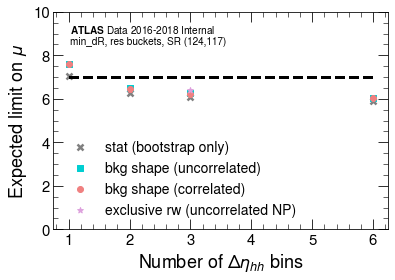

In [35]:
plt.scatter(db.index,db.stat,marker='x',color='grey',
            label='stat (bootstrap only)')
plt.scatter(db.index,db.syst,marker='s',color='darkturquoise',
            label='bkg shape (uncorrelated)')
plt.scatter(db.index,db['corr'],marker='o',color='lightcoral',
            label='bkg shape (correlated)')

plt.scatter([3],[6.42],marker='*',color='plum',
            label='exclusive rw (uncorrelated NP)')

plt.plot([1,6],[7]*2,'k--')

plt.xlabel('Number of $\Delta \eta_{hh}$ bins',fontsize=18)
plt.ylabel('Expected limit on $\mu$',fontsize=18)
plt.legend()

plt.ylim(0,10)
ax = plt.gca()

plt.text(0.05,0.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=10)

plt.savefig('figures/fullRun2/mu_vs_deta_bins_sr_124_117_res_bkts.pdf',bbox_inches='tight')